In [1]:
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import tensorboard as tb
from tensorboard.backend.event_processing import event_accumulator
from random import choices
from itertools import combinations

In [2]:
def age_debiasing(predicted_ages, chronological_ages):
    
    predicted_ages = predicted_ages.to_numpy()
    chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

def age_debiasing(predicted_ages, chronological_ages):
    
    predicted_ages = predicted_ages.to_numpy()
    chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

def tensorboard_reader(directory, tag='AgeDelta/epoch'):
    """
    Sources: 
    https://stackoverflow.com/questions/41074688/how-do-you-read-tensorboard-files-programmatically
    https://stackoverflow.com/questions/37304461/tensorflow-importing-data-from-a-tensorboard-tfevent-file
    """
    
    for dataset in ['train', 'validation']:
    
        dct = {}
        steps = []
        values = []
    
        if dataset == 'train':
            dir_name = directory + '/train/'
        else:
            dir_name = directory + '/validation/'

        list_of_files = os.listdir(dir_name)

        for file in list_of_files:
            file_name=dir_name+file
#             print(file_name)
            ea = event_accumulator.EventAccumulator(file_name,
              size_guidance={
              event_accumulator.COMPRESSED_HISTOGRAMS: 500,
              event_accumulator.IMAGES: 4,
              event_accumulator.AUDIO: 4,
              event_accumulator.SCALARS: 0,
              event_accumulator.HISTOGRAMS: 1,
          })
            ea.Reload()
#             print(ea.Tags())
            if tag in ea.Tags()['scalars']:
                for e in ea.Scalars(tag):
                    step = e.step
                    value = e.value
                    steps.append(step)
                    values.append(value)

        dct['step'] = steps
        
        if dataset == 'train':
            dct['train'] = values
            dfp = pd.DataFrame.from_dict(dct)
        else:
            dct['validation'] = values
            dfv = pd.DataFrame.from_dict(dct)

    df = pd.merge(dfp, dfv, how='left', on='step')
    df = df.sort_values('step')
    
    return df

def linear_plotter(x, y_train, y_validation, xlabel, ylabel, title, ylim_flag=False, xlim=None):
    
    if isinstance(x, np.ndarray):
        pass
    else:
        x = x.values
        y_train = y_train.values
        y_validation = y_validation.values
    
    plt.figure(figsize=[14.4,7.2])
    plt.plot(x, y_train, label='Train')
    plt.plot(x, y_validation, label='Validation')
    plt.xlabel(xlabel)
    if ylim_flag == True:
        ylim_min = -0.25
        ylim_max = np.max(y_train) + 5
        plt.ylim((ylim_min, ylim_max))
    best_validation = np.min(y_validation)
    best_epoch = x[np.where(y_validation == np.min(y_validation))[0][0]]
    best_train = y_train[np.where(y_validation == np.min(y_validation))[0][0]]
    gap = best_train - best_validation
    print(best_epoch, best_validation)
    print(-gap)
    plt.scatter(x=best_epoch, y=best_validation, s=100, marker='*', color='red', label='Selected Best Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()
    
def linear_plotter_comparison(Xs, Ys, Labels,
                              xlabel, ylabel, title, ylim_flag=False):
    
    plt.figure(figsize=[7,5])
    for idx, x in enumerate(Xs):
        plt.plot(x, Ys[idx], label=Labels[idx])
    plt.xlabel(xlabel)
    if ylim_flag == True:
        ylim_min = -0.25
        y_max = [np.max(Ys[idx]) for idx in range(len(Ys))]
        ylim_max = min(y_max)
        plt.ylim((ylim_min, ylim_max))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_everything(network='49', ylim2=[2.175, 2.45], control=False):
    dfs = []
    names = []
    range_points = [1,2,3]
#     network = '49'
    preambul = 'MM'
    if control == True:
        preambul = 'AM'
        range_points = [10,11,12]

    tag = 'AgeDelta/epoch'
    for i in range_points:
        name = preambul + str(int(i)) + '-' + network
        directory = '../logs/' + name
        df = tensorboard_reader(directory=directory, tag=tag)
        dfs.append(df)
        names.append(name)

    dfs2 = []
    names2 = []
    range_points = [1,2,3]
#     network = '49'

    tag2 = 'LearningRate/iteration'
    for i in range_points:
        name2 = preambul + str(int(i)) + '-' + network
        directory2 = '../logs/' + name
    #     if os.path.isdir(directory):
        df2 = tensorboard_reader(directory=directory2, tag=tag2)
        dfs2.append(df2)
        names2.append(name2)

    for i, df in enumerate(dfs):
        name = names[i]
        df = df.dropna(axis=0)
        linear_plotter(x=df.step, y_train=df.train, y_validation=df.validation, 
                       xlabel='Epochs', ylabel=tag, title=name, xlim=[-2, 300])

    Xs = [dfs[i].step.values for i in range(len(dfs))]
    Ys = [dfs[i].validation.values for i in range(len(dfs))]
    Labels = [preambul + str(int(i)) + '-' + network for i in range_points]
    xlabel='Epochs'
    ylabel='AgeDelta/epoch'

    plt.figure(figsize=[14.4,7.2])
    for idx, x in enumerate(Xs):
        y = Ys[idx]
        x = np.delete(x, np.argwhere(np.isnan(y)))
        y = np.delete(y, np.argwhere(np.isnan(y)))
        plt.plot(x, y, label=Labels[idx], alpha=0.3)
        best_validation = np.min(y)
        best_epoch = x[np.where(y == np.min(y))[0][0]]
        label = 'Selected Best Epoch for ' + Labels[idx]
        if idx < 3:
            plt.scatter(x=best_epoch, y=best_validation, s=150, marker='*', label=label)
        else:
            plt.scatter(x=best_epoch, y=best_validation, s=150, marker='o', label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.ylim(ylim2)
    plt.xlim([-1,300])
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')

#     for idx in range(len(dfs2)):
#         dfs2[idx].step = dfs2[idx].step / (dfs2[idx].step.max() / dfs[idx].step.max())

#     ncols=2
#     nrows=1
#     sz=7.2
#     title_font_size=22
#     ticks_font_size=18
#     legend_font = 18

#     for idx in range(len(dfs)):

#         fig, axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(ncols*sz,nrows*sz))

#         axes = axes.ravel()

#         axes[0] = plt.subplot()
#         ax2 = axes[0].twinx()
#         l1, = axes[0].plot(dfs[idx].step, dfs[idx].validation, color='tab:orange')
#         l2, = ax2.plot(dfs2[idx].step, dfs2[idx].train, linestyle='dotted', color='b')

#         best_validation = np.min(dfs[idx].validation.values)
#         best_epoch = dfs[idx].step.values[np.where(dfs[idx].validation.values == best_validation)[0][0]]
#         l3 = axes[0].scatter(x=best_epoch, y=best_validation, s=100, marker='*', color='red')


#         plt.legend([l1, l2, l3], ['Val Curve', 'LR', 'Selected Best Epoch'])




#         axes[0].set_ylabel('Age Delta')
#         ax2.set_ylabel('Learning Rate')
#         axes[0].set_xlabel('Training Epochs')
#         ax2.grid(linestyle='--')

#         axes[0].set_xlim([-2, 300])

In [3]:
!ls ../

Analysis Female - SWINp5 vs CNN     __init__.py
Analysis Female - hyperparam Search additionalCodes
Analysis Female - patch=5           attention_maps_prototype
Analysis Female - prototype         logs
Picture 1.png                       predictions
Picture 2.png                       saved_models
ThesisFigures                       testing_rick_data


In [4]:
df = pd.read_pickle('../../agemapper/Analsysis Female New/female_test.pkl')
df_test = {}
df_test['Unnamed: 0'] = df.iloc[0].dataframe['Unnamed: 0'].to_list()
for idx in range(len(df)):
    name = df.iloc[idx].modality
    data = df.iloc[idx].dataframe.mean_output_age.to_list()
    df_test[name] = data
    
df_test = pd.DataFrame.from_dict(df_test)
df_test['target_age'] = df.iloc[0].dataframe.target_age.to_list()

df_testA, df_testB = train_test_split(df_test, test_size=0.5, random_state=1)
subjectsA = df_testA['Unnamed: 0'].to_list()
subjectsB = df_testB['Unnamed: 0'].to_list()
del df_testA, df_testB, df

In [5]:

net1 = "2" # vanilla
net2 = '55' # p5,f48,pat40,steplr
# net3 = '3' # FA

dfs = [
    net1,
    net2,
#     net3
]

names = [

    'vanilla',           #1
    'p5,f48,pat40,steplr',           #2
#     'tbss_FA',           #3
]


dfs1, dfs2, dfs3 = [], [], []
dfs4, dfs5, dfs6 = [], [], []
dfs7, dfs8, dfs9 = [], [], []
dfs10, dfs11, dfs12 = [], [], []
# dfs13, dfs14, dfs15 = [], [], []

dfs1 = dfs.copy()
dfs2 = dfs.copy()
dfs3 = dfs.copy()
dfs4 = dfs.copy()
dfs5 = dfs.copy()
dfs6 = dfs.copy()
dfs7 = dfs.copy()
dfs8 = dfs.copy()
dfs9 = dfs.copy()
dfs10 = dfs.copy()
dfs11 = dfs.copy()
dfs12 = dfs.copy()
# dfs13 = dfs.copy()
# dfs14 = dfs.copy()
# dfs15 = dfs.copy()

for idx in range(len(dfs)):
    
    dfs1[idx] = '../predictions/SM0-' + dfs1[idx] + '_predictions/output_statistics_test.csv'
    dfs2[idx] = '../predictions/SM1-' + dfs2[idx] + '_predictions/output_statistics_test.csv'
    dfs3[idx] = '../predictions/SM2-' + dfs3[idx] + '_predictions/output_statistics_test.csv'
    dfs4[idx] = '../predictions/SM3-' + dfs4[idx] + '_predictions/output_statistics_test.csv'
    dfs5[idx] = '../predictions/SM4-' + dfs5[idx] + '_predictions/output_statistics_test.csv'
    dfs6[idx] = '../predictions/SM5-' + dfs6[idx] + '_predictions/output_statistics_test.csv'
    dfs7[idx] = '../predictions/SM6-' + dfs7[idx] + '_predictions/output_statistics_test.csv'
    dfs8[idx] = '../predictions/SM7-' + dfs8[idx] + '_predictions/output_statistics_test.csv'
    dfs9[idx] = '../predictions/SM8-' + dfs9[idx] + '_predictions/output_statistics_test.csv'
    dfs10[idx] = '../predictions/SM9-' + dfs10[idx] + '_predictions/output_statistics_test.csv'
    dfs11[idx] = '../predictions/SM10-' + dfs11[idx] + '_predictions/output_statistics_test.csv'
    dfs12[idx] = '../predictions/SM11-' + dfs12[idx] + '_predictions/output_statistics_test.csv'
#     dfs13[idx] = '../predictions/MM13-' + dfs13[idx] + '_predictions/output_statistics_test.csv'
#     dfs14[idx] = '../predictions/MM14-' + dfs14[idx] + '_predictions/output_statistics_test.csv'
#     dfs15[idx] = '../predictions/MM15-' + dfs15[idx] + '_predictions/output_statistics_test.csv'
    
for idx in range(len(dfs)):
    dfs1[idx] = pd.read_csv(dfs1[idx])
    dfs2[idx] = pd.read_csv(dfs2[idx])
    dfs3[idx] = pd.read_csv(dfs3[idx])
    dfs4[idx] = pd.read_csv(dfs4[idx])
    dfs5[idx] = pd.read_csv(dfs5[idx])
    dfs6[idx] = pd.read_csv(dfs6[idx])
    dfs7[idx] = pd.read_csv(dfs7[idx])
    dfs8[idx] = pd.read_csv(dfs8[idx])
    dfs9[idx] = pd.read_csv(dfs9[idx])
    dfs10[idx] = pd.read_csv(dfs10[idx])
    dfs11[idx] = pd.read_csv(dfs11[idx])
    dfs12[idx] = pd.read_csv(dfs12[idx])
#     dfs13[idx] = pd.read_csv(dfs13[idx])
#     dfs14[idx] = pd.read_csv(dfs14[idx])
#     dfs15[idx] = pd.read_csv(dfs15[idx])

# print(dfs1[0].shape)

# df_testA, _ = train_test_split(dfs1[0], test_size=0.5, random_state=1)
# subjects = df_testA['Unnamed: 0'].to_list()
# del df_testA

subjects = subjectsA

for idx in range(len(dfs)):
    for subj in dfs1[idx]['Unnamed: 0'].to_list():
        if subj not in subjects:
            dfs1[idx] = dfs1[idx].drop(dfs1[idx][dfs1[idx]['Unnamed: 0'] == subj].index)
            dfs2[idx] = dfs2[idx].drop(dfs2[idx][dfs2[idx]['Unnamed: 0'] == subj].index)
            dfs3[idx] = dfs3[idx].drop(dfs3[idx][dfs3[idx]['Unnamed: 0'] == subj].index)
            dfs4[idx] = dfs4[idx].drop(dfs4[idx][dfs4[idx]['Unnamed: 0'] == subj].index)
            dfs5[idx] = dfs5[idx].drop(dfs5[idx][dfs5[idx]['Unnamed: 0'] == subj].index)
            dfs6[idx] = dfs6[idx].drop(dfs6[idx][dfs6[idx]['Unnamed: 0'] == subj].index)
            dfs7[idx] = dfs7[idx].drop(dfs7[idx][dfs7[idx]['Unnamed: 0'] == subj].index)
            dfs8[idx] = dfs8[idx].drop(dfs8[idx][dfs8[idx]['Unnamed: 0'] == subj].index)
            dfs9[idx] = dfs9[idx].drop(dfs9[idx][dfs9[idx]['Unnamed: 0'] == subj].index)
            dfs10[idx] = dfs10[idx].drop(dfs10[idx][dfs10[idx]['Unnamed: 0'] == subj].index)
            dfs11[idx] = dfs11[idx].drop(dfs11[idx][dfs11[idx]['Unnamed: 0'] == subj].index)
            dfs12[idx] = dfs12[idx].drop(dfs12[idx][dfs12[idx]['Unnamed: 0'] == subj].index)
#             dfs13[idx] = dfs13[idx].drop(dfs13[idx][dfs13[idx]['Unnamed: 0'] == subj].index)
#             dfs14[idx] = dfs14[idx].drop(dfs14[idx][dfs14[idx]['Unnamed: 0'] == subj].index)
#             dfs15[idx] = dfs15[idx].drop(dfs15[idx][dfs15[idx]['Unnamed: 0'] == subj].index)
    
for idx in range(len(dfs)):
    dfs[idx] = pd.merge(dfs1[idx], dfs2[idx], on='Unnamed: 0', how='inner')
    dfs[idx] = pd.merge(dfs[idx], dfs3[idx], on='Unnamed: 0', how='inner')
    
    dfs[idx].rename({
        'target_age_x': 'target_age_original',
        'output_age_x': 'output_age_1',
        'age_delta_x': 'age_delta_1',
        'loss_x': 'loss_1',
        'target_age_y': 'target_age_2',
        'output_age_y': 'output_age_2',
        'age_delta_y': 'age_delta_2',
        'loss_y': 'loss_2',
        'target_age': 'target_age_3',
        'output_age': 'output_age_3',
        'age_delta': 'age_delta_3',
        'loss': 'loss_3',
    }, axis=1, inplace=True)
    
    dfs[idx].drop(['target_age_2', 'target_age_3'], axis=1, inplace=True)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs4[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_4',
        'age_delta': 'age_delta_4',
        'loss': 'loss_4',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs5[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_5',
        'age_delta': 'age_delta_5',
        'loss': 'loss_5',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs6[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_6',
        'age_delta': 'age_delta_6',
        'loss': 'loss_6',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
      
    
    dfs[idx] = pd.merge(dfs[idx], dfs7[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_7',
        'age_delta': 'age_delta_7',
        'loss': 'loss_7',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs8[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_8',
        'age_delta': 'age_delta_8',
        'loss': 'loss_8',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs9[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_9',
        'age_delta': 'age_delta_9',
        'loss': 'loss_9',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs10[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_10',
        'age_delta': 'age_delta_10',
        'loss': 'loss_10',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs11[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_11',
        'age_delta': 'age_delta_11',
        'loss': 'loss_11',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs12[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_12',
        'age_delta': 'age_delta_12',
        'loss': 'loss_12',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
#     dfs[idx] = pd.merge(dfs[idx], dfs13[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_13',
#         'age_delta': 'age_delta_13',
#         'loss': 'loss_13',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs14[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_14',
#         'age_delta': 'age_delta_14',
#         'loss': 'loss_14',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs15[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_15',
#         'age_delta': 'age_delta_15',
#         'loss': 'loss_15',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)

    
    
    
    dfs[idx].rename({
        'target_age_original': 'target_age',
    }, axis=1, inplace=True)
    
    dfs[idx]['mean_output_age'] = dfs[idx][['output_age_1', 'output_age_2', 'output_age_3',
                                           'output_age_4', 'output_age_5', 'output_age_6',
                                           'output_age_7', 'output_age_8', 'output_age_9',
                                           'output_age_10', 'output_age_11', 'output_age_12',
#                                             'output_age_13', 'output_age_14', 'output_age_15',
                                           
                                           ]].mean(axis=1)
    dfs[idx]['mean_age_delta'] = dfs[idx]['mean_output_age'] - dfs[idx]['target_age']
    
for idx in range(len(dfs)):    
    dfs[idx]['output_age_decon'] = age_debiasing(dfs[idx].mean_output_age, dfs[idx].target_age) 
    dfs[idx]['age_delta_decon'] = dfs[idx].output_age_decon - dfs[idx].target_age

d = {'modality':names, 'dataframe':dfs}
df = pd.DataFrame(data=d)
df.to_pickle('female_test_testA_convergence.pkl', protocol = 4)

In [6]:
dfs1

[      Unnamed: 0  target_age  output_age  age_delta       loss
 0       24806531   67.670660   66.096640  -1.574020   2.477540
 2       24748274   58.301940   55.597250  -2.704689   7.315343
 8       25763083   64.341210   64.204660  -0.136551   0.018646
 14      23070767   49.429646   52.562386   3.132740   9.814060
 15      23105121   55.055820   57.457264   2.401444   5.766931
 ...          ...         ...         ...        ...        ...
 5008    24067497   54.946690   52.118366  -2.828323   7.999413
 5011    23273678   58.773857   61.707040   2.933182   8.603556
 5014    21419039   72.986410   72.313225  -0.673187   0.453181
 5015    25475074   59.848515   59.008617  -0.839897   0.705427
 5018    21157566   78.016556   74.003300  -4.013252  16.106194
 
 [2510 rows x 5 columns],
       Unnamed: 0  target_age  output_age  age_delta       loss
 0       24806531   67.670660   67.140780  -0.529884   0.280777
 2       24748274   58.301940   55.721115  -2.580826   6.660662
 8       257

In [7]:

net1 = "2" # vanilla
net2 = '55' # p5,f48,pat40,steplr
# net3 = '3' # FA

dfs = [
    net1,
    net2,
#     net3
]

names = [

    'vanilla',           #1
    'p5,f48,pat40,steplr',           #2
]

dfs1, dfs2, dfs3 = [], [], []
dfs4, dfs5, dfs6 = [], [], []
dfs7, dfs8, dfs9 = [], [], []
dfs10, dfs11, dfs12 = [], [], []
# dfs13, dfs14, dfs15 = [], [], []

dfs1 = dfs.copy()
dfs2 = dfs.copy()
dfs3 = dfs.copy()
dfs4 = dfs.copy()
dfs5 = dfs.copy()
dfs6 = dfs.copy()
dfs7 = dfs.copy()
dfs8 = dfs.copy()
dfs9 = dfs.copy()
dfs10 = dfs.copy()
dfs11 = dfs.copy()
dfs12 = dfs.copy()
# dfs13 = dfs.copy()
# dfs14 = dfs.copy()
# dfs15 = dfs.copy()

for idx in range(len(dfs)):
    
    dfs1[idx] = '../predictions/SM0-' + dfs1[idx] + '_predictions/output_statistics_test.csv'
    dfs2[idx] = '../predictions/SM1-' + dfs2[idx] + '_predictions/output_statistics_test.csv'
    dfs3[idx] = '../predictions/SM2-' + dfs3[idx] + '_predictions/output_statistics_test.csv'
    dfs4[idx] = '../predictions/SM3-' + dfs4[idx] + '_predictions/output_statistics_test.csv'
    dfs5[idx] = '../predictions/SM4-' + dfs5[idx] + '_predictions/output_statistics_test.csv'
    dfs6[idx] = '../predictions/SM5-' + dfs6[idx] + '_predictions/output_statistics_test.csv'
    dfs7[idx] = '../predictions/SM6-' + dfs7[idx] + '_predictions/output_statistics_test.csv'
    dfs8[idx] = '../predictions/SM7-' + dfs8[idx] + '_predictions/output_statistics_test.csv'
    dfs9[idx] = '../predictions/SM8-' + dfs9[idx] + '_predictions/output_statistics_test.csv'
    dfs10[idx] = '../predictions/SM9-' + dfs10[idx] + '_predictions/output_statistics_test.csv'
    dfs11[idx] = '../predictions/SM10-' + dfs11[idx] + '_predictions/output_statistics_test.csv'
    dfs12[idx] = '../predictions/SM11-' + dfs12[idx] + '_predictions/output_statistics_test.csv'
#     dfs13[idx] = '../predictions/MM13-' + dfs13[idx] + '_predictions/output_statistics_test.csv'
#     dfs14[idx] = '../predictions/MM14-' + dfs14[idx] + '_predictions/output_statistics_test.csv'
#     dfs15[idx] = '../predictions/MM15-' + dfs15[idx] + '_predictions/output_statistics_test.csv'
    
for idx in range(len(dfs)):
    dfs1[idx] = pd.read_csv(dfs1[idx])
    dfs2[idx] = pd.read_csv(dfs2[idx])
    dfs3[idx] = pd.read_csv(dfs3[idx])
    dfs4[idx] = pd.read_csv(dfs4[idx])
    dfs5[idx] = pd.read_csv(dfs5[idx])
    dfs6[idx] = pd.read_csv(dfs6[idx])
    dfs7[idx] = pd.read_csv(dfs7[idx])
    dfs8[idx] = pd.read_csv(dfs8[idx])
    dfs9[idx] = pd.read_csv(dfs9[idx])
    dfs10[idx] = pd.read_csv(dfs10[idx])
    dfs11[idx] = pd.read_csv(dfs11[idx])
    dfs12[idx] = pd.read_csv(dfs12[idx])
#     dfs13[idx] = pd.read_csv(dfs13[idx])
#     dfs14[idx] = pd.read_csv(dfs14[idx])
#     dfs15[idx] = pd.read_csv(dfs15[idx])

    
# _, df_testB = train_test_split(dfs1[0], test_size=0.5, random_state=1)
# subjects = df_testB['Unnamed: 0'].to_list()
# del df_testB

subjects = subjectsB

for idx in range(len(dfs)):
    for subj in dfs1[idx]['Unnamed: 0'].to_list():
        if subj not in subjects:
            dfs1[idx] = dfs1[idx].drop(dfs1[idx][dfs1[idx]['Unnamed: 0'] == subj].index)
            dfs2[idx] = dfs2[idx].drop(dfs2[idx][dfs2[idx]['Unnamed: 0'] == subj].index)
            dfs3[idx] = dfs3[idx].drop(dfs3[idx][dfs3[idx]['Unnamed: 0'] == subj].index)
            dfs4[idx] = dfs4[idx].drop(dfs4[idx][dfs4[idx]['Unnamed: 0'] == subj].index)
            dfs5[idx] = dfs5[idx].drop(dfs5[idx][dfs5[idx]['Unnamed: 0'] == subj].index)
            dfs6[idx] = dfs6[idx].drop(dfs6[idx][dfs6[idx]['Unnamed: 0'] == subj].index)
            dfs7[idx] = dfs7[idx].drop(dfs7[idx][dfs7[idx]['Unnamed: 0'] == subj].index)
            dfs8[idx] = dfs8[idx].drop(dfs8[idx][dfs8[idx]['Unnamed: 0'] == subj].index)
            dfs9[idx] = dfs9[idx].drop(dfs9[idx][dfs9[idx]['Unnamed: 0'] == subj].index)
            dfs10[idx] = dfs10[idx].drop(dfs10[idx][dfs10[idx]['Unnamed: 0'] == subj].index)
            dfs11[idx] = dfs11[idx].drop(dfs11[idx][dfs11[idx]['Unnamed: 0'] == subj].index)
            dfs12[idx] = dfs12[idx].drop(dfs12[idx][dfs12[idx]['Unnamed: 0'] == subj].index)
#             dfs13[idx] = dfs13[idx].drop(dfs13[idx][dfs13[idx]['Unnamed: 0'] == subj].index)
#             dfs14[idx] = dfs14[idx].drop(dfs14[idx][dfs14[idx]['Unnamed: 0'] == subj].index)
#             dfs15[idx] = dfs15[idx].drop(dfs15[idx][dfs15[idx]['Unnamed: 0'] == subj].index)
    
for idx in range(len(dfs)):
    dfs[idx] = pd.merge(dfs1[idx], dfs2[idx], on='Unnamed: 0', how='inner')
    dfs[idx] = pd.merge(dfs[idx], dfs3[idx], on='Unnamed: 0', how='inner')
    
    dfs[idx].rename({
        'target_age_x': 'target_age_original',
        'output_age_x': 'output_age_1',
        'age_delta_x': 'age_delta_1',
        'loss_x': 'loss_1',
        'target_age_y': 'target_age_2',
        'output_age_y': 'output_age_2',
        'age_delta_y': 'age_delta_2',
        'loss_y': 'loss_2',
        'target_age': 'target_age_3',
        'output_age': 'output_age_3',
        'age_delta': 'age_delta_3',
        'loss': 'loss_3',
    }, axis=1, inplace=True)
    
    dfs[idx].drop(['target_age_2', 'target_age_3'], axis=1, inplace=True)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs4[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_4',
        'age_delta': 'age_delta_4',
        'loss': 'loss_4',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs5[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_5',
        'age_delta': 'age_delta_5',
        'loss': 'loss_5',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs6[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_6',
        'age_delta': 'age_delta_6',
        'loss': 'loss_6',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
      
    
    dfs[idx] = pd.merge(dfs[idx], dfs7[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_7',
        'age_delta': 'age_delta_7',
        'loss': 'loss_7',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs8[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_8',
        'age_delta': 'age_delta_8',
        'loss': 'loss_8',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs9[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_9',
        'age_delta': 'age_delta_9',
        'loss': 'loss_9',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs10[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_10',
        'age_delta': 'age_delta_10',
        'loss': 'loss_10',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs11[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_11',
        'age_delta': 'age_delta_11',
        'loss': 'loss_11',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs12[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_12',
        'age_delta': 'age_delta_12',
        'loss': 'loss_12',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
#     dfs[idx] = pd.merge(dfs[idx], dfs13[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_13',
#         'age_delta': 'age_delta_13',
#         'loss': 'loss_13',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs14[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_14',
#         'age_delta': 'age_delta_14',
#         'loss': 'loss_14',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs15[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_15',
#         'age_delta': 'age_delta_15',
#         'loss': 'loss_15',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)

    
    
    
    dfs[idx].rename({
        'target_age_original': 'target_age',
    }, axis=1, inplace=True)
    
    dfs[idx]['mean_output_age'] = dfs[idx][['output_age_1', 'output_age_2', 'output_age_3',
                                           'output_age_4', 'output_age_5', 'output_age_6',
                                           'output_age_7', 'output_age_8', 'output_age_9',
                                           'output_age_10', 'output_age_11', 'output_age_12',
#                                             'output_age_13', 'output_age_14', 'output_age_15',
                                           
                                           ]].mean(axis=1)
    dfs[idx]['mean_age_delta'] = dfs[idx]['mean_output_age'] - dfs[idx]['target_age']
    
for idx in range(len(dfs)):    
    dfs[idx]['output_age_decon'] = age_debiasing(dfs[idx].mean_output_age, dfs[idx].target_age) 
    dfs[idx]['age_delta_decon'] = dfs[idx].output_age_decon - dfs[idx].target_age

print("{:22} : {:7}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}  |  {:3}".format(
    'Modality', 'Run1', "Run2", "Run3", 'Run4', "Run5", "Run6", 'Run7', "Run8", "Run9", 'Run10', "Run11", "Run12",
#     'Run13', "Run14", "Run15",
    "MAE"))
print('-----------------------------------------------------------------------------------------------')

for idx in range(len(dfs)):
#     _, dfs[idx] = train_test_split(dfs[idx], test_size=0.5, random_state=1)
    print("{:22} : {:7.3f}  |  {:.3f} |  {:.3f} |  {:.3f}   |  {:.3f} |  {:.3f} |  {:.3f} |  {:.3f} |  {:.3f} |  {:.3f}   |  {:.3f} |  {:.3f} |  {:.3f}  ".format(
        names[idx],
        np.abs(dfs[idx].age_delta_1).mean(), 
        np.abs(dfs[idx].age_delta_2).mean(),
        np.abs(dfs[idx].age_delta_3).mean(),
        np.abs(dfs[idx].age_delta_4).mean(), 
        np.abs(dfs[idx].age_delta_5).mean(),
        np.abs(dfs[idx].age_delta_6).mean(),
        np.abs(dfs[idx].age_delta_7).mean(), 
        np.abs(dfs[idx].age_delta_8).mean(),
        np.abs(dfs[idx].age_delta_9).mean(),
        np.abs(dfs[idx].age_delta_10).mean(), 
        np.abs(dfs[idx].age_delta_11).mean(),
        np.abs(dfs[idx].age_delta_12).mean(),
#         np.abs(dfs[idx].age_delta_13).mean(), 
#         np.abs(dfs[idx].age_delta_14).mean(),
#         np.abs(dfs[idx].age_delta_15).mean(),
        np.abs(dfs[idx].mean_age_delta).mean(),
    )
         )
    
print('\n')    

print("{:23} : {:14}  |  {:13}  ".format('Modality', 'MEAN (MAE)', "MEAN DECONF"))
print('-----------------------------------------------------------------------------------------------')

for idx in range(len(dfs)):
    
#     _, dfs[idx]s = train_test_split(dfs[idx], test_size=0.5, random_state=1)
    
    print("{:23} :  {:.3f} |   {:.3f}  ".format(
        names[idx],
        np.abs(dfs[idx].mean_age_delta).mean(), 
        np.abs(dfs[idx].age_delta_decon).mean(),
    )
         )

# Modality               : Run1     |  Run2  |  Run3  |  Run4  |  Run5  |  Run6  |  Run7  |  Run8  |  Run9  
# |  Run10  |  Run11  |  Run12  |  MAE
# -----------------------------------------------------------------------------------------------
# T1_nonlinear           :   2.490  |  2.483 |  2.382 |  2.476   |  2.467 |  2.504 |  2.487 |  2.439 |  2.399 
# |  2.436   |  2.517 |  2.407 |  2.179  

# Modality                : MEAN (MAE)      |  MEAN DECONF    
# -----------------------------------------------------------------------------------------------
# T1_nonlinear            :  2.179 |   2.353  

Modality               : Run1     |  Run2  |  Run3  |  Run4  |  Run5  |  Run6  |  Run7  |  Run8  |  Run9  |  Run10  |  Run11  |  Run12  |  MAE
-----------------------------------------------------------------------------------------------
vanilla                :   2.397  |  2.415 |  2.563 |  2.439   |  2.473 |  2.421 |  2.427 |  2.407 |  2.449 |  2.418   |  2.514 |  2.463 |  2.289  
p5,f48,pat40,steplr    :   2.456  |  2.462 |  2.495 |  2.428   |  2.424 |  2.501 |  2.410 |  2.446 |  2.511 |  2.468   |  2.461 |  2.465 |  2.291  


Modality                : MEAN (MAE)      |  MEAN DECONF    
-----------------------------------------------------------------------------------------------
vanilla                 :  2.289 |   2.481  
p5,f48,pat40,steplr     :  2.291 |   2.493  


In [8]:
dfs4

[      Unnamed: 0  target_age  output_age  age_delta       loss
 1       24237795   77.280940   76.281685  -0.999252   0.998505
 3       25463415   58.056694   60.242530   2.185837   4.777883
 4       25313661   59.653084   59.584570  -0.068512   0.004694
 5       23521455   53.088700   52.233540  -0.855160   0.731298
 6       25206481   50.428654   51.158062   0.729408   0.532036
 ...          ...         ...         ...        ...        ...
 5012    25785977   55.227055   59.971836   4.744782  22.512950
 5013    25068363   61.883446   63.064710   1.181263   1.395382
 5016    22834218   60.501940   61.397526   0.895584   0.802071
 5017    24442683   56.130707   52.995953  -3.134754   9.826684
 5019    24018656   51.958560   56.100975   4.142414  17.159594
 
 [2510 rows x 5 columns],
       Unnamed: 0  target_age  output_age  age_delta       loss
 1       24237795   77.280940   73.369440  -3.911499  15.299825
 3       25463415   58.056694   57.799057  -0.257637   0.066377
 4       253

In [9]:
d = {'modality':names, 'dataframe':dfs}
df = pd.DataFrame(data=d)
df.to_pickle('female_test_testB_convergence.pkl', protocol = 4)

In [10]:
def convergencePlots(dfs, idx, names):
    MAEs2 = [np.abs(dfs[idx].age_delta_1).mean(), 
            np.abs(dfs[idx].age_delta_2).mean(),
            np.abs(dfs[idx].age_delta_3).mean(),
            np.abs(dfs[idx].age_delta_4).mean(), 
            np.abs(dfs[idx].age_delta_5).mean(),
            np.abs(dfs[idx].age_delta_6).mean(),
            np.abs(dfs[idx].age_delta_7).mean(), 
            np.abs(dfs[idx].age_delta_8).mean(),
            np.abs(dfs[idx].age_delta_9).mean(),
            np.abs(dfs[idx].age_delta_10).mean(), 
            np.abs(dfs[idx].age_delta_11).mean(),
            np.abs(dfs[idx].age_delta_12).mean(),
#         np.abs(dfs[idx].age_delta_13).mean(), 
#         np.abs(dfs[idx].age_delta_14).mean(),
#         np.abs(dfs[idx].age_delta_15).mean()
        ]
    MAEsSingle = MAEs2
    
    MAEs = []
    dfs = dfs[idx]

    nets = 0
    maePaths = []
    for col in dfs.columns.values:
        if 'output_age_' in col:
            maePaths.append(col)
            nets += 1

    if 'output_age_decon' in maePaths:
        maePaths.remove('output_age_decon')
        nets -= 1

    maePaths2 = []
    for path in maePaths:
        maePaths2.append(path)
        mean_output_age = dfs[maePaths2].mean(axis=1).to_numpy()
        mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
        mae = np.abs(mean_age_delta).mean()
        MAEs.append(mae)

    print('% Convergece MAEs')
    for i in np.arange(0, nets, 1):
        print(i+1, 1-(MAEs[i]-MAEs[-1])/(MAEs[0] - MAEs[-1]))

    fig, ax1 = plt.subplots(figsize=[12, 6], facecolor='white')
    ax1.plot(np.arange(1, nets+1, 1), MAEs, marker='o', label='MAE Convergence')
    # ax1.plot(np.arange(1, nets+1, 1), MAEs)
    ax1.set_xlabel('Number of Identical Runs')
    ax1.set_ylabel('Ensemble MAE')
    ax1.axhline(y = MAEs[-1], c='red', linestyle='--', alpha=0.5, label='Best MAE')
#     ax1.axhline(y = 2.038, c='green', linestyle='--', alpha=0.5, label='ElasticNet')
    ax1.legend()
    ax1.set_title(names[idx] + ' Single Convergence')

    bootstraps = 10000
    bootstrapsMAEs = []
    bootstrapsSTDs = []
    for i in range(1, len(MAEs2)+1):
        bootMaes = []
        for _ in range(bootstraps):
            if i != 1:
                bootChoice = choices(maePaths, k=i)
                mean_output_age = dfs[bootChoice].mean(axis=1).to_numpy()
                mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
                mae = np.abs(mean_age_delta).mean()
                bootMaes.append(mae)
            else:
                bootChoice = choices(MAEs2, k=i)
                bootMaes.append(bootChoice[0])  
        bootstrapsMAEs.append(np.mean(bootMaes))
        bootstrapsSTDs.append(np.std(bootMaes))

    print('% Bootstrapped MAEs')
    for i in np.arange(0, nets, 1):
        print(i+1, 1-(bootstrapsMAEs[i]-bootstrapsMAEs[-1])/(bootstrapsMAEs[0] - bootstrapsMAEs[-1]))

    fig, ax1 = plt.subplots(figsize=[12, 6], facecolor='white')
    ax1.plot(np.arange(1, nets+1, 1), MAEs, marker='o', label='MAE Convergence', alpha=0.25)
    # ax1.plot(np.arange(1, nets+1, 1), MAEs)
    ax1.set_xlabel('Number of Identical Runs')
    ax1.set_ylabel('Ensemble MAE')
    ax1.axhline(y = MAEs[-1], c='red', linestyle='--', alpha=0.5, label='Best CumSum MAE')
#     ax1.axhline(y = 2.038, c='green', linestyle='--', alpha=0.5, label='ElasticNet')
    ax1.errorbar(np.arange(1, nets+1, 1), bootstrapsMAEs, bootstrapsSTDs, c='black', marker='o',
                 label='Bootstrapped CumSum MAEs')
    ax1.set_title(names[idx] + ' Bootstrapped Convergence')
    ax1.legend()


    combMAEs = []
    combSTDs = []
    for i in range(1, len(MAEs2)+1):
        combMaes = []
        for comb in combinations(maePaths, i):
            comb = list(comb)
            if i!=1:
                mean_output_age = dfs[comb].mean(axis=1).to_numpy()
                mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
                mae = np.abs(mean_age_delta).mean()
                combMaes.append(mae)
            else:
                mean_output_age = dfs[comb[0]].to_numpy()
                mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
                mae = np.abs(mean_age_delta).mean()
                combMaes.append(mae)           
        combMAEs.append(np.mean(combMaes))
        combSTDs.append(np.std(combMaes))

    print('% Combined MAEs')
    for i in np.arange(0, nets, 1):
        print(i+1, 1-(combMAEs[i]-combMAEs[-1])/(combMAEs[0] - combMAEs[-1]))

    fig, ax1 = plt.subplots(figsize=[12, 6], facecolor='white')
    ax1.plot(np.arange(1, nets+1, 1), MAEs, marker='o', label='MAE Convergence', alpha=0.25)
    ax1.set_xlabel('Number of Identical Runs')
    ax1.set_ylabel('Ensemble MAE')
    ax1.axhline(y = MAEs[-1], c='red', linestyle='--', alpha=0.5, label='Best CumSum MAE')
#     ax1.axhline(y = 2.038, c='green', linestyle='--', alpha=0.5, label='ElasticNet')
    ax1.errorbar(np.arange(1, nets+1, 1), bootstrapsMAEs, bootstrapsSTDs, c='black', marker='o',
                 label='Bootstrapped CumSum MAEs', alpha=0.2)
    ax1.errorbar(np.arange(1, nets+1, 1), combMAEs, combSTDs, c='magenta', marker='o',
                 label='Combination CumSum MAEs')
    ax1.legend()
    ax1.set_title(names[idx] + ' Combined Convergence')

% Convergece MAEs
1 0.0
2 0.5906653938656087
3 0.6114574132602426
4 0.6822277513383879
5 0.6433588191672588
6 0.7791366937653684
7 0.8582790371151239
8 0.9173370249785604
9 0.954112689644327
10 1.025357134293141
11 1.0180087206113686
12 1.0
% Bootstrapped MAEs
1 0.0
2 0.5366475908707538
3 0.7240177363750899
4 0.8167289549357986
5 0.868960717413905
6 0.9058797300821609
7 0.9330947213996141
8 0.9515411377646197
9 0.9682319645417475
10 0.9821229941628373
11 0.9894417167833487
12 1.0
% Combined MAEs
1 0.0
2 0.541394683512999
3 0.7256571185581638
4 0.8178844178922922
5 0.8730851992106441
6 0.9095303131976353
7 0.9354496451480014
8 0.9548264074517557
9 0.9698919763628109
10 0.9817808921735435
11 0.9916053162259854
12 1.0


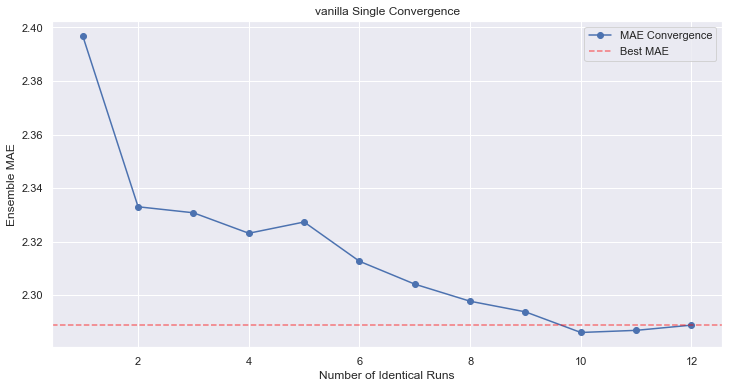

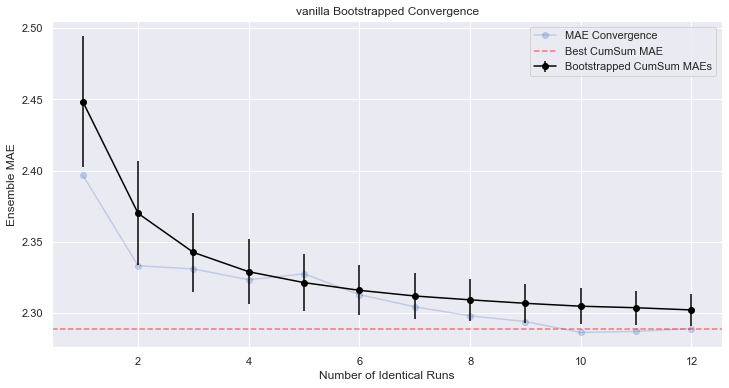

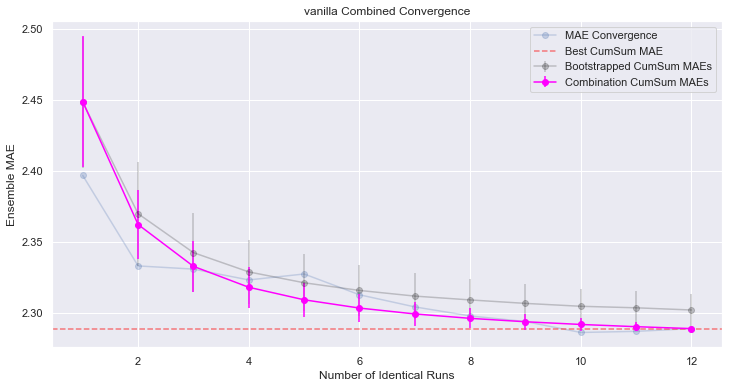

In [11]:
convergencePlots(dfs, 0, names)

% Convergece MAEs
1 0.0
2 0.49587386932173116
3 0.6491243441093539
4 0.7719835654098663
5 0.8972891961103218
6 0.8737465939630211
7 0.9412770673457236
8 0.9953487113647926
9 0.9619050935972089
10 0.9905948980651382
11 0.9972727637773685
12 1.0
% Bootstrapped MAEs
1 0.0
2 0.5401329494897154
3 0.723483577464243
4 0.811117980458859
5 0.8712662820975168
6 0.9071715671796257
7 0.9313332492668414
8 0.9526993949005486
9 0.96903997078827
10 0.9815447201403635
11 0.9906010198014559
12 1.0
% Combined MAEs
1 0.0
2 0.5355763732655716
3 0.718513580189444
4 0.8102580357983311
5 0.8656695140466497
6 0.9030405147401002
7 0.9302171062886535
8 0.9508988470286327
9 0.9672892256149481
10 0.9806752443763153
11 0.9917765509612948
12 1.0


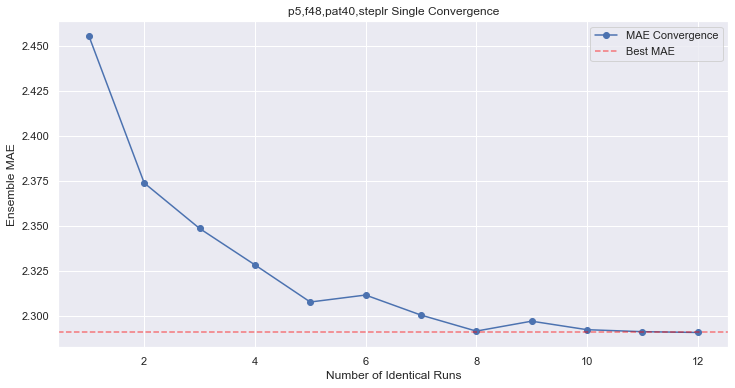

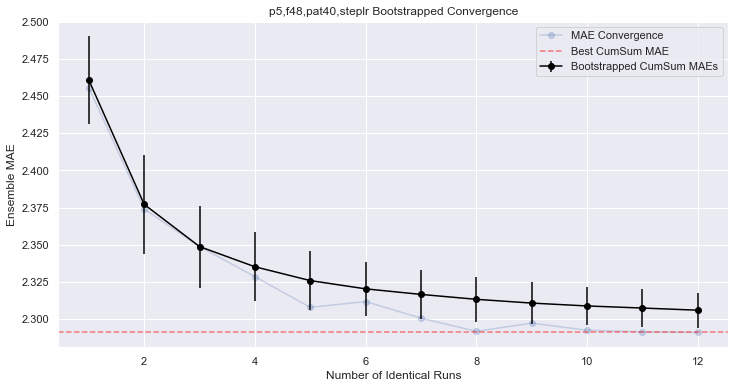

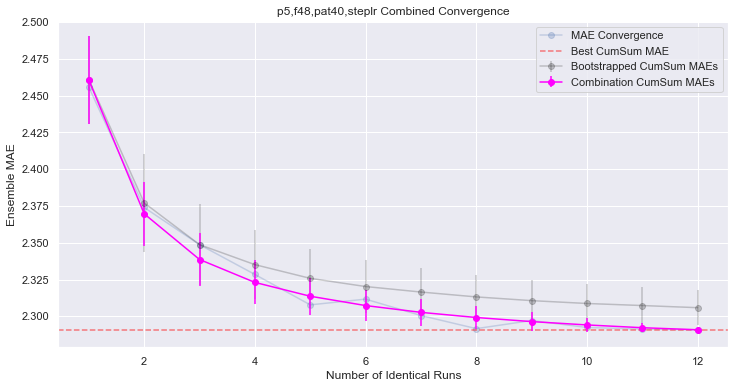

In [12]:
convergencePlots(dfs, 1, names)

In [ ]:
# convergencePlots(dfs, 2, names)

In [28]:
def convergencePlotsXTRA(dfs, idx, names, title):
    MAEs2 = [np.abs(dfs[idx].age_delta_1).mean(), 
            np.abs(dfs[idx].age_delta_2).mean(),
            np.abs(dfs[idx].age_delta_3).mean(),
            np.abs(dfs[idx].age_delta_4).mean(), 
            np.abs(dfs[idx].age_delta_5).mean(),
            np.abs(dfs[idx].age_delta_6).mean(),
            np.abs(dfs[idx].age_delta_7).mean(), 
            np.abs(dfs[idx].age_delta_8).mean(),
            np.abs(dfs[idx].age_delta_9).mean(),
            np.abs(dfs[idx].age_delta_10).mean(), 
            np.abs(dfs[idx].age_delta_11).mean(),
            np.abs(dfs[idx].age_delta_12).mean(),
#         np.abs(dfs[idx].age_delta_13).mean(), 
#         np.abs(dfs[idx].age_delta_14).mean(),
#         np.abs(dfs[idx].age_delta_15).mean()
        ]
    MAEsSingle = MAEs2
    
    MAEs = []
    dfs = dfs[idx]

    nets = 0
    maePaths = []
    for col in dfs.columns.values:
        if 'output_age_' in col:
            maePaths.append(col)
            nets += 1

    if 'output_age_decon' in maePaths:
        maePaths.remove('output_age_decon')
        nets -= 1

    maePaths2 = []
    for path in maePaths:
        maePaths2.append(path)
        mean_output_age = dfs[maePaths2].mean(axis=1).to_numpy()
        mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
        mae = np.abs(mean_age_delta).mean()
        MAEs.append(mae)

    print('% Convergece MAEs')
    for i in np.arange(0, nets, 1):
        print(np.round(1-(MAEs[i]-MAEs[-1])/(MAEs[0] - MAEs[-1]), 3))
    print('^^^')
    for i in np.arange(0, nets, 1):
        print(np.round(MAEs[i], 3))


    bootstraps = 10000
    bootstrapsMAEs = []
    bootstrapsSTDs = []
    for i in range(1, len(MAEs2)+1):
        bootMaes = []
        for _ in range(bootstraps):
            if i != 1:
                bootChoice = choices(maePaths, k=i)
                mean_output_age = dfs[bootChoice].mean(axis=1).to_numpy()
                mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
                mae = np.abs(mean_age_delta).mean()
                bootMaes.append(mae)
            else:
                bootChoice = choices(MAEs2, k=i)
                bootMaes.append(bootChoice[0])  
        bootstrapsMAEs.append(np.mean(bootMaes))
        bootstrapsSTDs.append(np.std(bootMaes))

    print('% Bootstrapped MAEs')
    for i in np.arange(0, nets, 1):
        print(np.round(1-(bootstrapsMAEs[i]-bootstrapsMAEs[-1])/(bootstrapsMAEs[0] - bootstrapsMAEs[-1]),3))
    print('^^^')
    for i in np.arange(0, nets, 1):
        print(np.round(bootstrapsMAEs[i], 3))


    combMAEs = []
    combSTDs = []
    for i in range(1, len(MAEs2)+1):
        combMaes = []
        for comb in combinations(maePaths, i):
            comb = list(comb)
            if i!=1:
                mean_output_age = dfs[comb].mean(axis=1).to_numpy()
                mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
                mae = np.abs(mean_age_delta).mean()
                combMaes.append(mae)
            else:
                mean_output_age = dfs[comb[0]].to_numpy()
                mean_age_delta = mean_output_age - dfs['target_age'].to_numpy()
                mae = np.abs(mean_age_delta).mean()
                combMaes.append(mae)           
        combMAEs.append(np.mean(combMaes))
        combSTDs.append(np.std(combMaes))

    print('% Combined MAEs')
    for i in np.arange(0, nets, 1):
        print(np.round(1-(combMAEs[i]-combMAEs[-1])/(combMAEs[0] - combMAEs[-1]),3))
    print('^^^')
    for i in np.arange(0, nets, 1):
        print(np.round(combMAEs[i], 3))

    title_font_size=22
    ticks_font_size=18
    legend_font = 18
    figsize=(16, 9.6)
    alpha=0.75

    fig, ax1 = plt.subplots(figsize=figsize, facecolor='white')

    ax1.plot(np.arange(1, nets+1, 1), MAEs, marker='o', label='Naive Ensemble', alpha=1)

    ax1.set_xlabel('Number of Identical Runs', fontsize=title_font_size)
    ax1.set_ylabel('Ensemble MAE (years)', fontsize=title_font_size)

    ax1.axhline(y = MAEs[-1], c='green', linestyle='--', alpha=alpha, label='Best Naive Ensemble MAE')

    ax1.errorbar(np.arange(1, nets+1, 1), bootstrapsMAEs, bootstrapsSTDs, c='black', marker='o',
                 label='Bootstrapped MAEs', alpha=alpha, capsize=3)

    ax1.errorbar(np.arange(1, nets+1, 1), combMAEs, combSTDs, c='magenta', marker='o',
                 label='Combinatorial MAEs',capsize=3, alpha=alpha)

    ax1.tick_params(axis='both', labelsize=ticks_font_size)


    # Create a combined legend for ax1 and ax2
    legend_ax1, labels_ax1 = ax1.get_legend_handles_labels()
    ax1.legend(legend_ax1, labels_ax1,
               loc='lower center', bbox_to_anchor=(0.5, -0.25),
               ncol=3, fancybox=True, shadow=True, fontsize=legend_font)


    plt.title(title, fontsize=title_font_size)
    plt.savefig(title + '.png', bbox_inches='tight', facecolor='white')

% Convergece MAEs
0.0
0.591
0.611
0.682
0.643
0.779
0.858
0.917
0.954
1.025
1.018
1.0
^^^
2.397
2.333
2.331
2.323
2.327
2.313
2.304
2.298
2.294
2.286
2.287
2.289
% Bootstrapped MAEs
0.0
0.543
0.727
0.818
0.873
0.909
0.934
0.955
0.97
0.982
0.993
1.0
^^^
2.449
2.369
2.342
2.329
2.321
2.315
2.312
2.309
2.307
2.305
2.303
2.302
% Combined MAEs
0.0
0.541
0.726
0.818
0.873
0.91
0.935
0.955
0.97
0.982
0.992
1.0
^^^
2.449
2.362
2.333
2.318
2.309
2.303
2.299
2.296
2.294
2.292
2.29
2.289


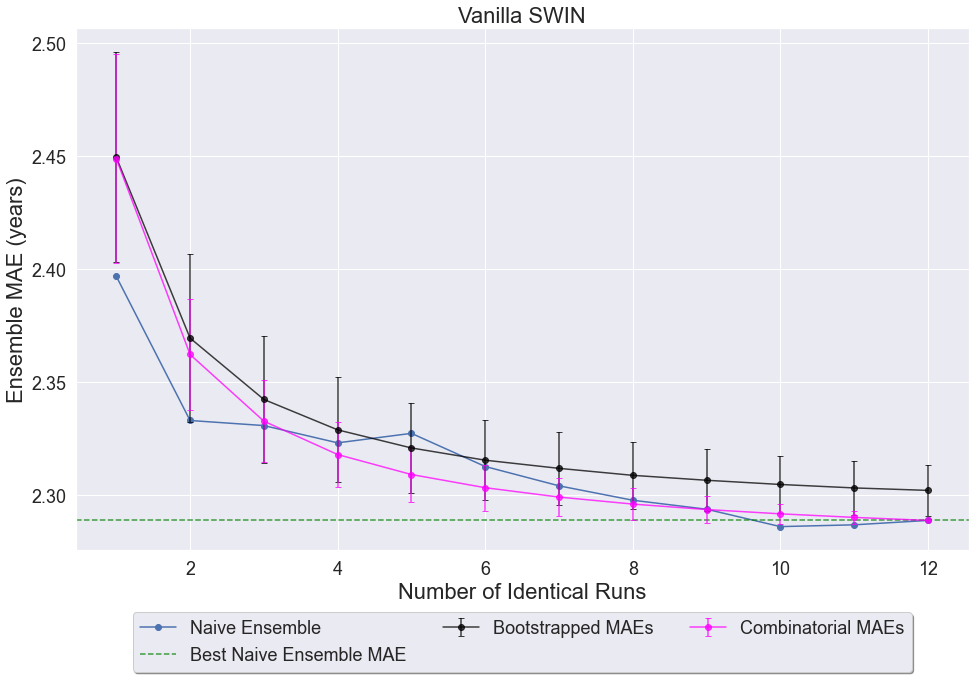

In [29]:
convergencePlotsXTRA(dfs, 0, names, title='Vanilla SWIN')

% Convergece MAEs
0.0
0.496
0.649
0.772
0.897
0.874
0.941
0.995
0.962
0.991
0.997
1.0
^^^
2.456
2.374
2.349
2.328
2.308
2.312
2.301
2.292
2.297
2.292
2.291
2.291
% Bootstrapped MAEs
0.0
0.541
0.722
0.816
0.865
0.907
0.934
0.952
0.968
0.981
0.993
1.0
^^^
2.461
2.377
2.349
2.334
2.327
2.32
2.316
2.313
2.311
2.309
2.307
2.306
% Combined MAEs
0.0
0.536
0.719
0.81
0.866
0.903
0.93
0.951
0.967
0.981
0.992
1.0
^^^
2.461
2.37
2.339
2.323
2.314
2.307
2.303
2.299
2.296
2.294
2.292
2.291


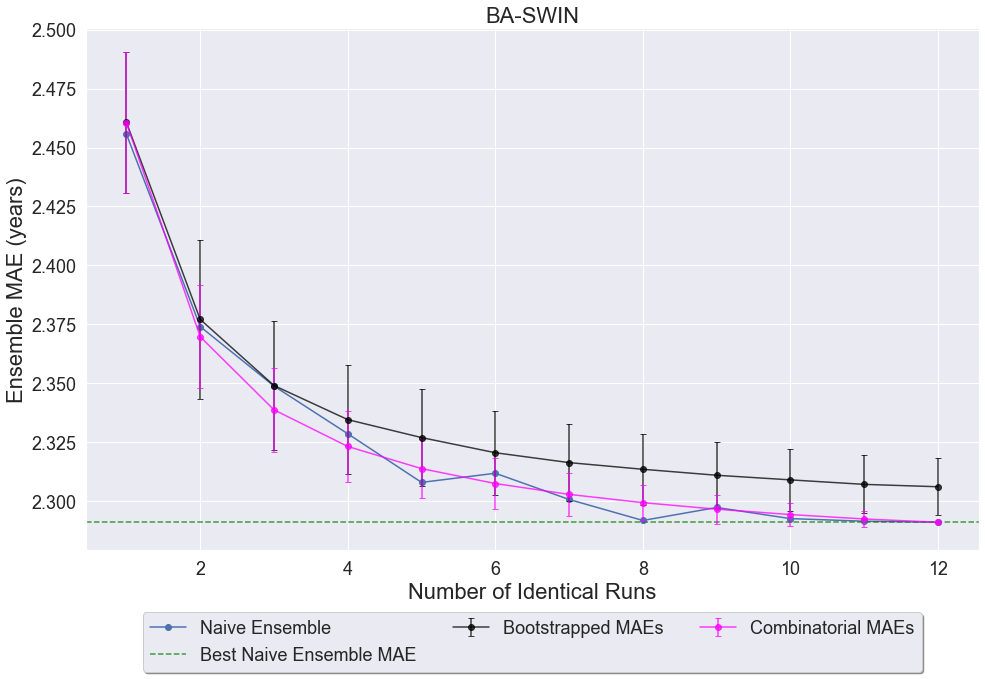

In [31]:
convergencePlotsXTRA(dfs, 1, names, title='BA-SWIN')

In [1]:
import pandas as pd
from scipy.stats import pearsonr

In [3]:
df = pd.read_pickle('female_test_testB_convergence.pkl')

In [4]:
df

,modality,dataframe
0,vanilla,Unnamed: 0 target_age output_age_1 ag...
1,"p5,f48,pat40,steplr",Unnamed: 0 target_age output_age_1 ag...


In [5]:
df.iloc[0].dataframe

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,...,output_age_11,age_delta_11,loss_11,output_age_12,age_delta_12,loss_12,mean_output_age,mean_age_delta,output_age_decon,age_delta_decon
0,24237795,77.280940,78.818400,1.537460,2.363784,77.248090,-0.032845,0.001079,73.003700,-4.277237,...,77.247360,-0.033577,0.001127,76.558600,-0.722336,0.521769,76.702871,-0.578069,79.095214,1.814274
1,25463415,58.056694,59.786156,1.729462,2.991038,59.988520,1.931828,3.731958,58.892105,0.835411,...,61.786896,3.730202,13.914405,60.963684,2.906990,8.450591,59.964648,1.907954,59.323598,1.266904
2,25313661,59.653084,60.252045,0.598961,0.358754,60.983814,1.330730,1.770844,59.957380,0.304295,...,58.906757,-0.746326,0.557003,58.852480,-0.800602,0.640964,59.057751,-0.595333,58.252348,-1.400736
3,23521455,53.088700,53.661730,0.573032,0.328366,52.227220,-0.861481,0.742149,52.315693,-0.773006,...,53.320477,0.231777,0.053721,53.252693,0.163994,0.026894,53.644980,0.556280,51.858645,-1.230055
4,25206481,50.428654,52.374870,1.946217,3.787759,50.241924,-0.186729,0.034868,50.706787,0.278133,...,49.858765,-0.569889,0.324774,51.515700,1.087048,1.181672,51.111459,0.682805,48.865985,-1.562669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2505,25785977,55.227055,60.966366,5.739311,32.939693,60.906292,5.679237,32.253740,61.868473,6.641419,...,60.250730,5.023674,25.237300,61.218050,5.990994,35.892002,60.621263,5.394208,60.099209,4.872154
2506,25068363,61.883446,62.464890,0.581444,0.338077,63.891790,2.008343,4.033441,63.060158,1.176712,...,64.291534,2.408089,5.798891,61.402992,-0.480453,0.230836,62.942078,1.058632,62.840615,0.957169
2507,22834218,60.501940,59.926830,-0.575111,0.330753,59.652700,-0.849243,0.721214,65.956245,5.454304,...,61.521700,1.019760,1.039911,61.064130,0.562187,0.316054,60.946204,0.444264,60.483038,-0.018902
2508,24442683,56.130707,54.165280,-1.965427,3.862905,53.800680,-2.330029,5.429033,54.390842,-1.739864,...,53.483154,-2.647553,7.009534,52.648895,-3.481812,12.123012,53.876329,-2.254378,52.131920,-3.998787


In [9]:
pearsonr(df.iloc[0].dataframe.mean_age_delta, df.iloc[1].dataframe.mean_age_delta)[0]

0.8943285260876869

In [8]:
pearsonr(df.iloc[0].dataframe.age_delta_decon, df.iloc[1].dataframe.age_delta_decon)[0]

0.8743552063220698

In [13]:
!ls '../../agemapper/predictions/AC7-1_predictions'

output_statistics_test.csv


In [4]:

net1 = "1" # T1NL
net2 = '2' # T2NL
net3 = '3' # FA

dfs = [
    net1,
    net2,
    net3
]

names = [

    'T1_nonlinear',           #1
    'T2_nonlinear',           #2
    'tbss_FA',           #3
]


dfs1, dfs2, dfs3 = [], [], []
dfs4, dfs5, dfs6 = [], [], []
dfs7, dfs8, dfs9 = [], [], []
dfs10, dfs11, dfs12 = [], [], []
# dfs13, dfs14, dfs15 = [], [], []

dfs1 = dfs.copy()
dfs2 = dfs.copy()
dfs3 = dfs.copy()
dfs4 = dfs.copy()
dfs5 = dfs.copy()
dfs6 = dfs.copy()
dfs7 = dfs.copy()
dfs8 = dfs.copy()
dfs9 = dfs.copy()
dfs10 = dfs.copy()
dfs11 = dfs.copy()
dfs12 = dfs.copy()
# dfs13 = dfs.copy()
# dfs14 = dfs.copy()
# dfs15 = dfs.copy()

for idx in range(len(dfs)):
    
    dfs1[idx] = '../../agemapper/predictions/AC1-' + dfs1[idx] + '_predictions/output_statistics_test.csv'
    dfs2[idx] = '../../agemapper/predictions/AC2-' + dfs2[idx] + '_predictions/output_statistics_test.csv'
    dfs3[idx] = '../../agemapper/predictions/AC3-' + dfs3[idx] + '_predictions/output_statistics_test.csv'
    dfs4[idx] = '../../agemapper/predictions/AC4-' + dfs4[idx] + '_predictions/output_statistics_test.csv'
    dfs5[idx] = '../../agemapper/predictions/AC5-' + dfs5[idx] + '_predictions/output_statistics_test.csv'
    dfs6[idx] = '../../agemapper/predictions/AC6-' + dfs6[idx] + '_predictions/output_statistics_test.csv'
    dfs7[idx] = '../../agemapper/predictions/AC7-' + dfs7[idx] + '_predictions/output_statistics_test.csv'
    dfs8[idx] = '../../agemapper/predictions/AC8-' + dfs8[idx] + '_predictions/output_statistics_test.csv'
    dfs9[idx] = '../../agemapper/predictions/AC9-' + dfs9[idx] + '_predictions/output_statistics_test.csv'
    dfs10[idx] = '../../agemapper/predictions/AC10-' + dfs10[idx] + '_predictions/output_statistics_test.csv'
    dfs11[idx] = '../../agemapper/predictions/AC11-' + dfs11[idx] + '_predictions/output_statistics_test.csv'
    dfs12[idx] = '../../agemapper/predictions/AC12-' + dfs12[idx] + '_predictions/output_statistics_test.csv'
#     dfs13[idx] = '../predictions/MM13-' + dfs13[idx] + '_predictions/output_statistics_test.csv'
#     dfs14[idx] = '../predictions/MM14-' + dfs14[idx] + '_predictions/output_statistics_test.csv'
#     dfs15[idx] = '../predictions/MM15-' + dfs15[idx] + '_predictions/output_statistics_test.csv'
    
for idx in range(len(dfs)):
    dfs1[idx] = pd.read_csv(dfs1[idx])
    dfs2[idx] = pd.read_csv(dfs2[idx])
    dfs3[idx] = pd.read_csv(dfs3[idx])
    dfs4[idx] = pd.read_csv(dfs4[idx])
    dfs5[idx] = pd.read_csv(dfs5[idx])
    dfs6[idx] = pd.read_csv(dfs6[idx])
    dfs7[idx] = pd.read_csv(dfs7[idx])
    dfs8[idx] = pd.read_csv(dfs8[idx])
    dfs9[idx] = pd.read_csv(dfs9[idx])
    dfs10[idx] = pd.read_csv(dfs10[idx])
    dfs11[idx] = pd.read_csv(dfs11[idx])
    dfs12[idx] = pd.read_csv(dfs12[idx])
#     dfs13[idx] = pd.read_csv(dfs13[idx])
#     dfs14[idx] = pd.read_csv(dfs14[idx])
#     dfs15[idx] = pd.read_csv(dfs15[idx])

# print(dfs1[0].shape)

# df_testA, _ = train_test_split(dfs1[0], test_size=0.5, random_state=1)
# subjects = df_testA['Unnamed: 0'].to_list()
# del df_testA

# subjects = subjectsA

# for idx in range(len(dfs)):
#     for subj in dfs1[idx]['Unnamed: 0'].to_list():
#         if subj not in subjects:
#             dfs1[idx] = dfs1[idx].drop(dfs1[idx][dfs1[idx]['Unnamed: 0'] == subj].index)
#             dfs2[idx] = dfs2[idx].drop(dfs2[idx][dfs2[idx]['Unnamed: 0'] == subj].index)
#             dfs3[idx] = dfs3[idx].drop(dfs3[idx][dfs3[idx]['Unnamed: 0'] == subj].index)
#             dfs4[idx] = dfs4[idx].drop(dfs4[idx][dfs4[idx]['Unnamed: 0'] == subj].index)
#             dfs5[idx] = dfs5[idx].drop(dfs5[idx][dfs5[idx]['Unnamed: 0'] == subj].index)
#             dfs6[idx] = dfs6[idx].drop(dfs6[idx][dfs6[idx]['Unnamed: 0'] == subj].index)
#             dfs7[idx] = dfs7[idx].drop(dfs7[idx][dfs7[idx]['Unnamed: 0'] == subj].index)
#             dfs8[idx] = dfs8[idx].drop(dfs8[idx][dfs8[idx]['Unnamed: 0'] == subj].index)
#             dfs9[idx] = dfs9[idx].drop(dfs9[idx][dfs9[idx]['Unnamed: 0'] == subj].index)
#             dfs10[idx] = dfs10[idx].drop(dfs10[idx][dfs10[idx]['Unnamed: 0'] == subj].index)
#             dfs11[idx] = dfs11[idx].drop(dfs11[idx][dfs11[idx]['Unnamed: 0'] == subj].index)
#             dfs12[idx] = dfs12[idx].drop(dfs12[idx][dfs12[idx]['Unnamed: 0'] == subj].index)
# #             dfs13[idx] = dfs13[idx].drop(dfs13[idx][dfs13[idx]['Unnamed: 0'] == subj].index)
# #             dfs14[idx] = dfs14[idx].drop(dfs14[idx][dfs14[idx]['Unnamed: 0'] == subj].index)
# #             dfs15[idx] = dfs15[idx].drop(dfs15[idx][dfs15[idx]['Unnamed: 0'] == subj].index)
    
for idx in range(len(dfs)):
    dfs[idx] = pd.merge(dfs1[idx], dfs2[idx], on='Unnamed: 0', how='inner')
    dfs[idx] = pd.merge(dfs[idx], dfs3[idx], on='Unnamed: 0', how='inner')
    
    dfs[idx].rename({
        'target_age_x': 'target_age_original',
        'output_age_x': 'output_age_1',
        'age_delta_x': 'age_delta_1',
        'loss_x': 'loss_1',
        'target_age_y': 'target_age_2',
        'output_age_y': 'output_age_2',
        'age_delta_y': 'age_delta_2',
        'loss_y': 'loss_2',
        'target_age': 'target_age_3',
        'output_age': 'output_age_3',
        'age_delta': 'age_delta_3',
        'loss': 'loss_3',
    }, axis=1, inplace=True)
    
    dfs[idx].drop(['target_age_2', 'target_age_3'], axis=1, inplace=True)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs4[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_4',
        'age_delta': 'age_delta_4',
        'loss': 'loss_4',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs5[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_5',
        'age_delta': 'age_delta_5',
        'loss': 'loss_5',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs6[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_6',
        'age_delta': 'age_delta_6',
        'loss': 'loss_6',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
      
    
    dfs[idx] = pd.merge(dfs[idx], dfs7[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_7',
        'age_delta': 'age_delta_7',
        'loss': 'loss_7',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs8[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_8',
        'age_delta': 'age_delta_8',
        'loss': 'loss_8',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs9[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_9',
        'age_delta': 'age_delta_9',
        'loss': 'loss_9',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs10[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_10',
        'age_delta': 'age_delta_10',
        'loss': 'loss_10',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs11[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_11',
        'age_delta': 'age_delta_11',
        'loss': 'loss_11',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs12[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_12',
        'age_delta': 'age_delta_12',
        'loss': 'loss_12',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
#     dfs[idx] = pd.merge(dfs[idx], dfs13[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_13',
#         'age_delta': 'age_delta_13',
#         'loss': 'loss_13',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs14[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_14',
#         'age_delta': 'age_delta_14',
#         'loss': 'loss_14',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs15[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_15',
#         'age_delta': 'age_delta_15',
#         'loss': 'loss_15',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)

    
    
    
    dfs[idx].rename({
        'target_age_original': 'target_age',
    }, axis=1, inplace=True)
    
    dfs[idx]['mean_output_age'] = dfs[idx][['output_age_1', 'output_age_2', 'output_age_3',
                                           'output_age_4', 'output_age_5', 'output_age_6',
                                           'output_age_7', 'output_age_8', 'output_age_9',
                                           'output_age_10', 'output_age_11', 'output_age_12',
#                                             'output_age_13', 'output_age_14', 'output_age_15',
                                           
                                           ]].mean(axis=1)
    dfs[idx]['mean_age_delta'] = dfs[idx]['mean_output_age'] - dfs[idx]['target_age']
    
for idx in range(len(dfs)):    
    dfs[idx]['output_age_decon'] = age_debiasing(dfs[idx].mean_output_age, dfs[idx].target_age) 
    dfs[idx]['age_delta_decon'] = dfs[idx].output_age_decon - dfs[idx].target_age
    

d = {'modality':names, 'dataframe':dfs}
df = pd.DataFrame(data=d)
df.to_pickle('female_test_testAB_convergence.pkl', protocol = 4)

In [5]:
df

,modality,dataframe
0,T1_nonlinear,Unnamed: 0 target_age output_age_1 ag...
1,T2_nonlinear,Unnamed: 0 target_age output_age_1 ag...
2,tbss_FA,Unnamed: 0 target_age output_age_1 ag...


In [7]:
df.iloc[1].dataframe

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,...,output_age_11,age_delta_11,loss_11,output_age_12,age_delta_12,loss_12,mean_output_age,mean_age_delta,output_age_decon,age_delta_decon
0,24806531,67.670662,68.509550,0.838890,0.703736,73.236336,5.565674,30.976723,72.469410,4.798752,...,67.621710,-0.048950,0.002396,70.132860,2.462196,6.062410,69.851513,2.180851,70.776984,3.106322
1,24237795,77.280936,76.850940,-0.429999,0.184899,74.938800,-2.342139,5.485615,78.419160,1.138223,...,76.098120,-1.182814,1.399050,75.777910,-1.503028,2.259092,75.633327,-1.647609,77.489465,0.208529
2,24748274,58.301941,60.355747,2.053807,4.218121,59.923730,1.621788,2.630197,58.820050,0.518109,...,59.685055,1.383114,1.913005,57.841217,-0.460724,0.212266,58.772884,0.470943,57.915086,-0.386855
3,25463415,58.056694,61.848972,3.792278,14.381375,62.835796,4.779102,22.839819,60.216755,2.160061,...,63.521996,5.465302,29.869521,60.785140,2.728447,7.444423,61.296279,3.239585,60.844659,2.787965
4,25313661,59.653082,60.947903,1.294820,1.676560,60.419190,0.766107,0.586920,57.766880,-1.886202,...,58.648655,-1.004427,1.008874,60.147797,0.494714,0.244742,58.963701,-0.689381,58.136618,-1.516464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,25475074,59.848516,62.857624,3.009108,9.054731,62.820805,2.972289,8.834500,60.481663,0.633147,...,60.859707,1.011191,1.022507,61.452835,1.604319,2.573840,61.467480,1.618964,61.043416,1.194900
5016,22834218,60.501941,57.904080,-2.597861,6.748883,58.575005,-1.926936,3.713083,56.741596,-3.760344,...,57.539840,-2.962100,8.774036,58.751710,-1.750232,3.063311,57.542317,-2.959623,56.486441,-4.015499
5017,24442683,56.130708,50.748410,-5.382298,28.969137,51.016910,-5.113797,26.150922,51.090538,-5.040170,...,51.773450,-4.357259,18.985704,50.709030,-5.421678,29.394588,51.306848,-4.823860,49.247281,-6.883426
5018,21157566,78.016553,75.256096,-2.760457,7.620121,78.811740,0.795185,0.632318,75.354380,-2.662175,...,76.750330,-1.266224,1.603324,76.324200,-1.692349,2.864045,76.358549,-1.658003,78.331422,0.314870


In [16]:
df.iloc[0].dataframe

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,...,age_delta_10,loss_10,output_age_11,age_delta_11,loss_11,output_age_12,age_delta_12,loss_12,mean_output_age,mean_age_delta
0,24806531,67.670662,64.726204,-2.944458,8.669834,66.424330,-1.246330,1.553340,66.316270,-1.354393,...,-0.610771,0.373042,69.418700,1.748039,3.055641,66.360090,-1.310570,1.717594,66.478513,-1.192149
1,24237795,77.280936,76.979040,-0.301894,0.091140,77.346240,0.065301,0.004264,74.377570,-2.903365,...,-0.322165,0.103790,75.516110,-1.764823,3.114599,76.485700,-0.795234,0.632396,75.303802,-1.977134
2,24748274,58.301941,57.279945,-1.021995,1.044474,56.228138,-2.073803,4.300658,57.169243,-1.132698,...,1.268334,1.608670,53.557194,-4.744747,22.512623,55.584213,-2.717727,7.386042,57.106949,-1.194992
3,25463415,58.056694,60.786385,2.729691,7.451211,61.961230,3.904537,15.245411,62.527927,4.471233,...,1.707302,2.914881,59.613407,1.556713,2.423356,63.573227,5.516533,30.432136,61.113865,3.057171
4,25313661,59.653082,57.004158,-2.648924,7.016799,61.199238,1.546156,2.390597,59.094430,-0.558653,...,0.476839,0.227375,61.302555,1.649473,2.720761,64.037704,4.384622,19.224913,60.801987,1.148905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,25475074,59.848516,60.156013,0.307498,0.094555,57.860980,-1.987535,3.950295,61.940810,2.092295,...,-0.629835,0.396692,58.006657,-1.841859,3.392446,60.832810,0.984293,0.968834,59.858550,0.010034
5016,22834218,60.501941,61.140970,0.639028,0.408356,60.546100,0.044160,0.001950,62.522500,2.020558,...,2.239984,5.017527,63.856876,3.354936,11.255594,58.742660,-1.759280,3.095067,61.782158,1.280217
5017,24442683,56.130708,54.246284,-1.884423,3.551051,56.046710,-0.083997,0.007055,55.240536,-0.890172,...,0.658954,0.434220,55.617130,-0.513577,0.263762,54.933945,-1.196763,1.432242,55.130943,-0.999764
5018,21157566,78.016553,76.624460,-1.392094,1.937926,77.201096,-0.815457,0.664970,75.565315,-2.451237,...,-0.715642,0.512143,75.804504,-2.212048,4.893157,76.253460,-1.763089,3.108482,76.916506,-1.100046


In [17]:
df.iloc[0].dataframe

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,...,age_delta_10,loss_10,output_age_11,age_delta_11,loss_11,output_age_12,age_delta_12,loss_12,mean_output_age,mean_age_delta
0,24806531,67.670662,64.726204,-2.944458,8.669834,66.424330,-1.246330,1.553340,66.316270,-1.354393,...,-0.610771,0.373042,69.418700,1.748039,3.055641,66.360090,-1.310570,1.717594,66.478513,-1.192149
1,24237795,77.280936,76.979040,-0.301894,0.091140,77.346240,0.065301,0.004264,74.377570,-2.903365,...,-0.322165,0.103790,75.516110,-1.764823,3.114599,76.485700,-0.795234,0.632396,75.303802,-1.977134
2,24748274,58.301941,57.279945,-1.021995,1.044474,56.228138,-2.073803,4.300658,57.169243,-1.132698,...,1.268334,1.608670,53.557194,-4.744747,22.512623,55.584213,-2.717727,7.386042,57.106949,-1.194992
3,25463415,58.056694,60.786385,2.729691,7.451211,61.961230,3.904537,15.245411,62.527927,4.471233,...,1.707302,2.914881,59.613407,1.556713,2.423356,63.573227,5.516533,30.432136,61.113865,3.057171
4,25313661,59.653082,57.004158,-2.648924,7.016799,61.199238,1.546156,2.390597,59.094430,-0.558653,...,0.476839,0.227375,61.302555,1.649473,2.720761,64.037704,4.384622,19.224913,60.801987,1.148905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,25475074,59.848516,60.156013,0.307498,0.094555,57.860980,-1.987535,3.950295,61.940810,2.092295,...,-0.629835,0.396692,58.006657,-1.841859,3.392446,60.832810,0.984293,0.968834,59.858550,0.010034
5016,22834218,60.501941,61.140970,0.639028,0.408356,60.546100,0.044160,0.001950,62.522500,2.020558,...,2.239984,5.017527,63.856876,3.354936,11.255594,58.742660,-1.759280,3.095067,61.782158,1.280217
5017,24442683,56.130708,54.246284,-1.884423,3.551051,56.046710,-0.083997,0.007055,55.240536,-0.890172,...,0.658954,0.434220,55.617130,-0.513577,0.263762,54.933945,-1.196763,1.432242,55.130943,-0.999764
5018,21157566,78.016553,76.624460,-1.392094,1.937926,77.201096,-0.815457,0.664970,75.565315,-2.451237,...,-0.715642,0.512143,75.804504,-2.212048,4.893157,76.253460,-1.763089,3.108482,76.916506,-1.100046


In [18]:
from scipy.stats import pearsonr

In [19]:
pearsonr(df.iloc[0].dataframe.mean_age_delta, df.iloc[2].dataframe.mean_age_delta)

(0.6526461140505284, 0.0)

In [21]:
df.iloc[0].dataframe.to_csv('female_test_testAB_convergence_T1.csv')
df.iloc[1].dataframe.to_csv('female_test_testAB_convergence_T2.csv')
df.iloc[2].dataframe.to_csv('female_test_testAB_convergence_FA.csv')

In [23]:
df.iloc[0].dataframe[['Unnamed: 0', 'target_age', 'mean_output_age']].to_csv('female_test_testAB_convergence_T1.csv')
df.iloc[1].dataframe[['Unnamed: 0', 'target_age', 'mean_output_age']].to_csv('female_test_testAB_convergence_T2.csv')
df.iloc[2].dataframe[['Unnamed: 0', 'target_age', 'mean_output_age']].to_csv('female_test_testAB_convergence_FA.csv')

In [24]:
df.iloc[0].dataframe[['Unnamed: 0', 'target_age', 'mean_output_age']]

,Unnamed: 0,target_age,mean_output_age
0,24806531,67.670662,66.478513
1,24237795,77.280936,75.303802
2,24748274,58.301941,57.106949
3,25463415,58.056694,61.113865
4,25313661,59.653082,60.801987
...,...,...,...
5015,25475074,59.848516,59.858550
5016,22834218,60.501941,61.782158
5017,24442683,56.130708,55.130943
5018,21157566,78.016553,76.916506
